In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib widget
# %matplotlib inline
import os
from scipy.stats import gaussian_kde
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/"
else:
  file_dir = "H:/github/python/seafog/"

def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

In [3]:
file_59754 = os.path.normpath(os.path.join(file_dir, './data/station/59754.by_5min_20200101-20221029.csv'))
df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])
df_59754.index = pd.to_datetime(df_59754["DDATETIME"])

df_code = pd.read_csv(os.path.normpath(os.path.join(file_dir, './code_readme.csv')),sep=',')

C:\Users\Henry\AppData\Local\Temp\ipykernel_14188\3080230640.py:2: DtypeWarning: Columns (12,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])


In [ ]:
print(df_59754.columns)

In [4]:
code_info = {
  'vis01':'V20059',
  'vis_01min':'V20001_701_01',
  'vis_10min':'V20001_701_10',
  'vis':'V20001',
  'td': 'V12003',
  't2m': 'V12001',
  "year":"V04001",
  "month": "V04002",
  "day": "V04003",
  "hour":"V04004",
  "minute":"V04005",
  "rhum":"V13003",
  'rain01':'V13019',
}

In [5]:
# 筛选雾出现的行

df_fog = df_59754.loc[df_59754[code_info['vis_01min']]<=1000]
df_fog = df_fog.loc[df_fog[code_info['rain01']] < 1].loc[df_fog[code_info['rhum']] > 80]
print(df_fog)


                                 DDATETIME  V01301               D_RYMDHM  \
DDATETIME                                                                   
2020-12-27 18:30:00  2020-12-27 18:30:00.0   59754  2020-12-27 18:30:26.0   
2020-12-27 18:40:00  2020-12-27 18:40:00.0   59754  2020-12-27 18:40:26.0   
2020-12-27 18:55:00  2020-12-27 18:55:00.0   59754  2020-12-27 18:55:26.0   
2020-12-27 19:00:00  2020-12-27 19:00:00.0   59754  2020-12-27 19:00:40.0   
2020-12-27 20:05:00  2020-12-27 20:05:00.0   59754  2020-12-27 20:05:24.0   
...                                    ...     ...                    ...   
2022-04-21 22:00:00  2022-04-21 22:00:00.0   59754  2022-08-20 19:42:00.0   
2022-04-21 22:05:00  2022-04-21 22:05:00.0   59754  2022-04-21 22:05:32.0   
2022-04-21 22:10:00  2022-04-21 22:10:00.0   59754  2022-04-21 22:10:32.0   
2022-04-21 22:15:00  2022-04-21 22:15:00.0   59754  2022-04-21 22:15:32.0   
2022-04-21 22:20:00  2022-04-21 22:20:00.0   59754  2022-04-21 22:20:33.0   

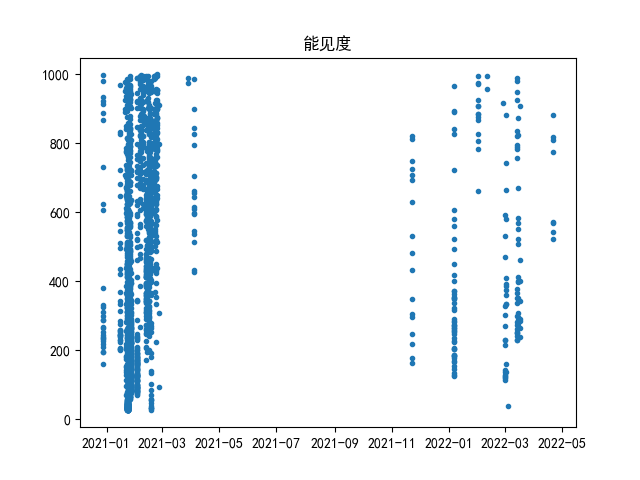

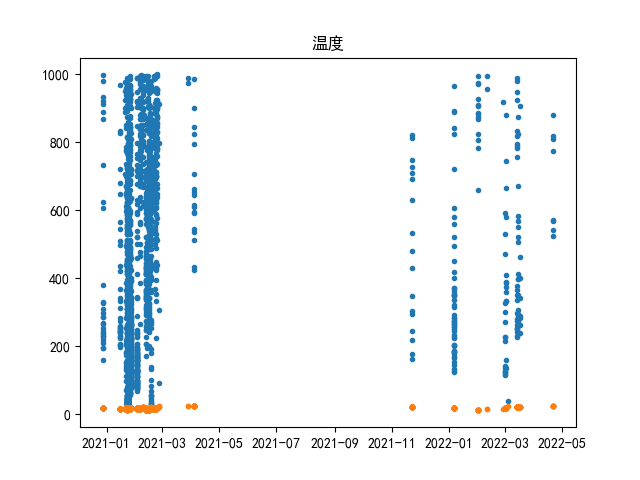

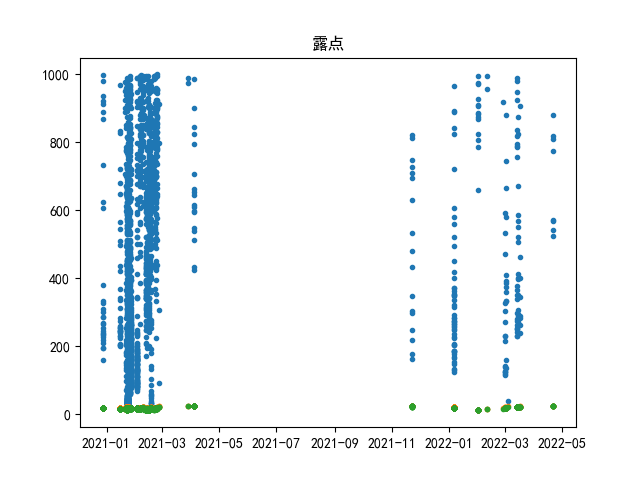

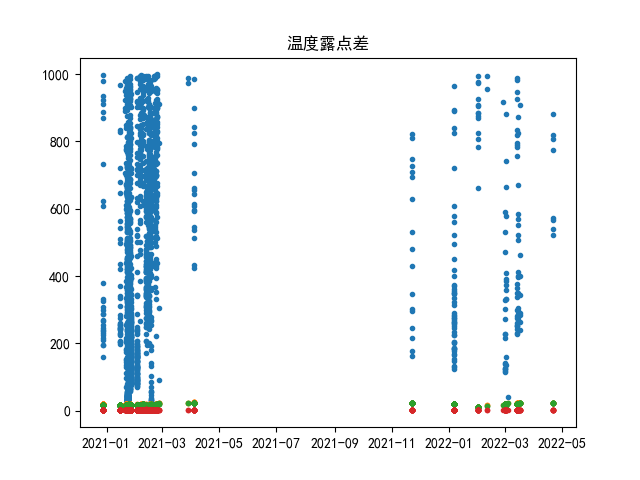

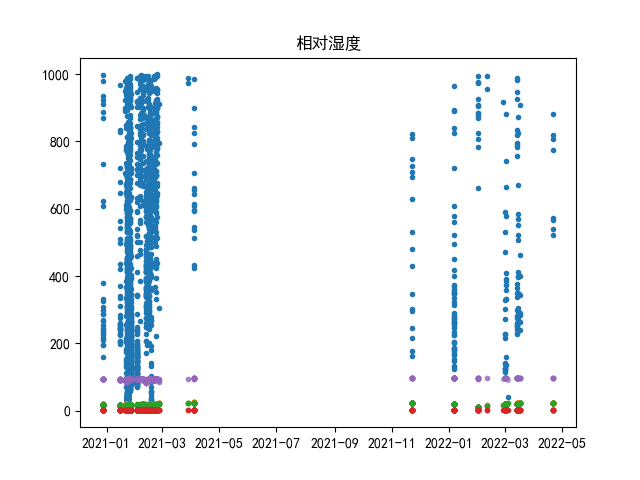

In [6]:
plt.plot(df_fog.index, df_fog[code_info['vis_01min']], '.')
plt.title('能见度')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['t2m']], '.')
plt.title('温度')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['td']], '.')
plt.title('露点')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['t2m']]-df_fog[code_info['td']], '.')
plt.title('温度露点差')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['rhum']], '.', alpha=0.5)
plt.title('相对湿度')
plt.show()

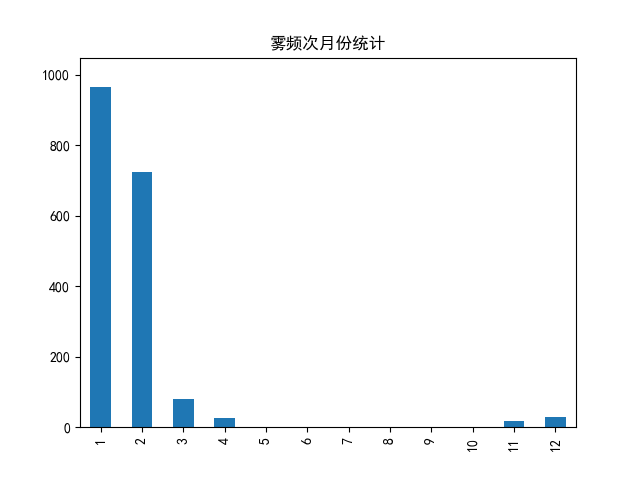

In [8]:
month_count = df_fog[code_info["month"]].value_counts().sort_index()
# print(month_count)
for index in range(12):
    month = index + 1
    if(month not in month_count.index):
      month_count.loc[month] = 0
month_count = month_count.sort_index()
month_count.plot.bar(title='雾频次月份统计')
plt.show()

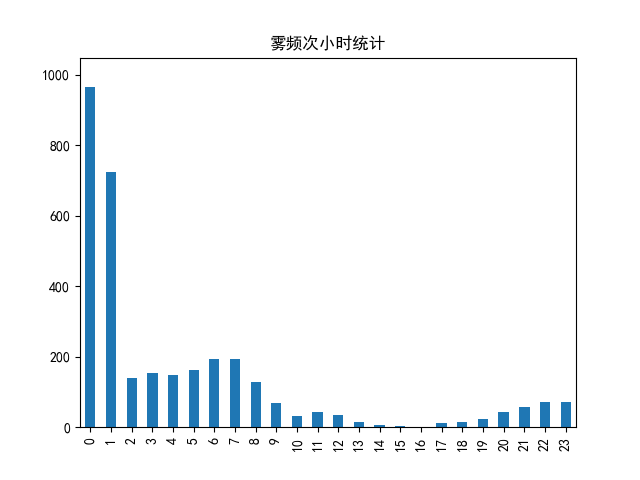

In [9]:
hour_count = df_fog[code_info["hour"]].value_counts().sort_index()
# hour_count.plot.bar()
# plt.show()
BJ_hour_count = pd.Series(np.arange(0,24))
for index in range(len(BJ_hour_count)):
    utc_index = index - 8 if index - 8>=0 else index - 8 +24
    BJ_hour_count[index] = hour_count.loc[utc_index] if utc_index in hour_count.index else 0

BJ_hour_count.plot.bar(title='雾频次小时统计')
plt.show()

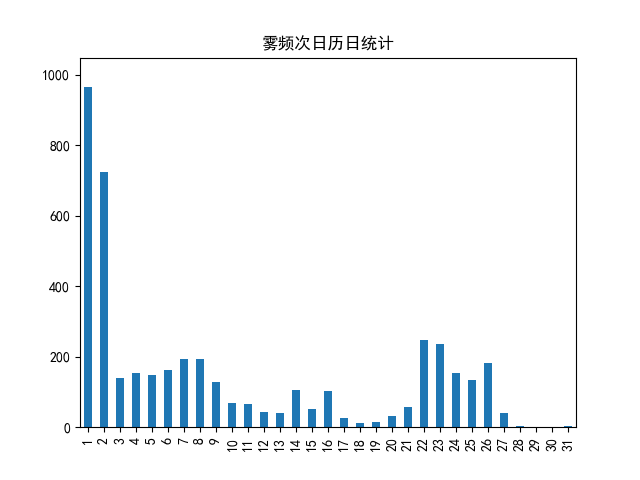

In [11]:
day_count = df_fog[code_info["day"]].value_counts().sort_index()
for index in range(31):
    day = index + 1
    if(day not in day_count.index):
      day_count.loc[day] = 0
day_count = day_count.sort_index()
day_count.plot.bar(title='雾频次日历日统计')
plt.show()

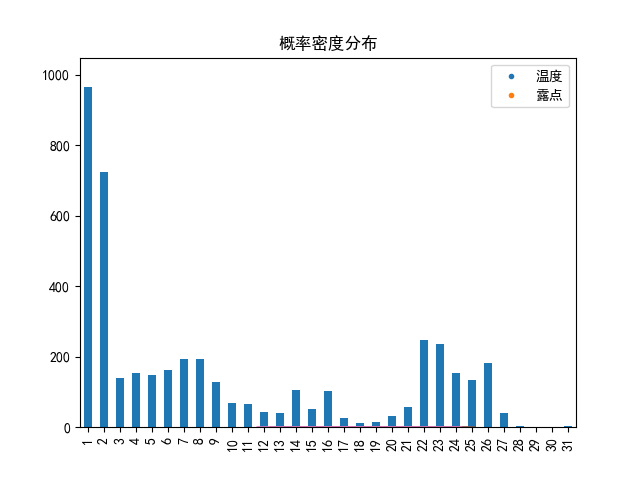

In [12]:
# 高斯分布概率密度函数
t2m = df_fog[code_info['t2m']]
eval_points = np.linspace(np.min(t2m), np.max(t2m), num = 100)
kde_sp = gaussian_kde(t2m, bw_method=0.15)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)


data_raw = df_fog[code_info['td']]
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.15)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('概率密度分布')
plt.legend(['温度','露点'])
plt.show()

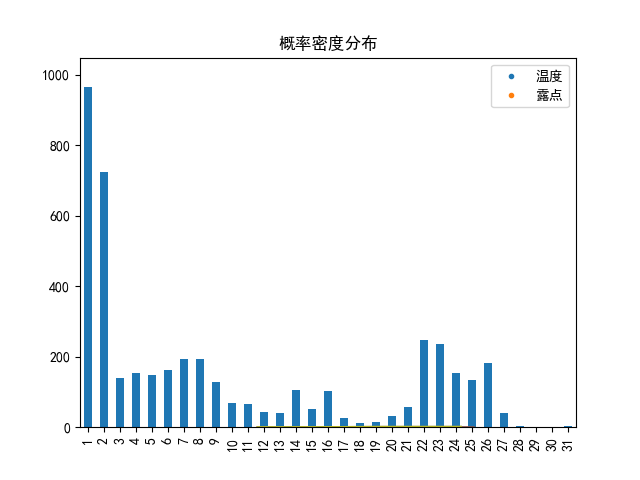

In [14]:
from scipy.special import ndtr
cdf = tuple(ndtr(np.ravel(item - kde_sp.dataset) / kde_sp.factor).mean()
                for item in eval_points)
plt.plot(eval_points, cdf)
plt.show()

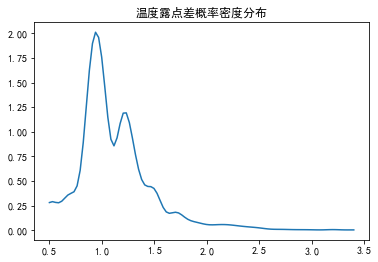

In [16]:
data_raw = df_fog[code_info['t2m']] - df_fog[code_info['td']]
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.2)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('温度露点差概率密度分布')
plt.show()

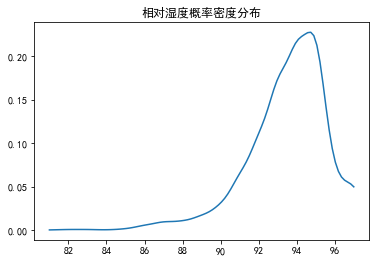

In [17]:
data_raw = df_fog[code_info['rhum']]
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.25)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('相对湿度概率密度分布')
plt.show()

In [18]:
ds_G7425 = pd.read_hdf(os.path.normpath(os.path.join(file_dir, './data/G7425/G7425_202012to202209.hdf')), mode='r')

In [ ]:
df_fog.index

In [ ]:
ds_G7425.index

In [19]:
bjtime_index = df_fog.index.to_series() + pd.Timedelta(8,unit='h')

In [20]:
inter_index = ds_G7425.index.intersection(bjtime_index)
utc_inter_index = inter_index.to_series() + pd.Timedelta(-8,unit='h')
df_fog_inter = df_fog.loc[utc_inter_index]

In [ ]:
print(inter_index)

In [21]:
ds_G7425_fogFilter = ds_G7425.loc[inter_index].dropna(subset=['SeaTemperature', 'RelativeHumidity','Temperature'])
print(ds_G7425_fogFilter)

                            ObserveTime  WindSpeed  WindDirect  Rain  \
date                                                                   
2020-12-28 02:30:00 2020-12-28 02:30:00        2.4        66.0   0.0   
2020-12-28 02:40:00 2020-12-28 02:40:00        2.0        89.0   0.0   
2020-12-28 03:00:00 2020-12-28 03:00:00        2.7        97.0   0.0   
2020-12-28 04:10:00 2020-12-28 04:10:00        2.5       124.0   0.0   
2020-12-28 04:20:00 2020-12-28 04:20:00        2.5       112.0   0.0   
...                                 ...        ...         ...   ...   
2022-03-17 05:10:00 2022-03-17 05:10:00        3.0        49.0   0.0   
2022-04-22 05:50:00 2022-04-22 05:50:00        3.7        84.0   0.0   
2022-04-22 06:00:00 2022-04-22 06:00:00        4.0        87.0   0.0   
2022-04-22 06:10:00 2022-04-22 06:10:00        4.5        88.0   0.0   
2022-04-22 06:20:00 2022-04-22 06:20:00        4.6        90.0   0.0   

                     MaxWindSpeed  MaxWindDirect  Temperature  

<AxesSubplot:xlabel='date'>

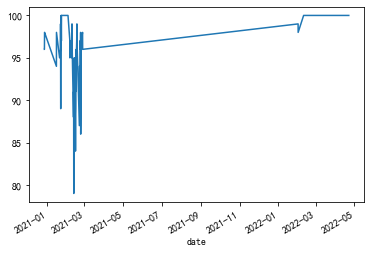

In [22]:
ds_G7425_fogFilter['RelativeHumidity'].plot()

In [23]:
rhum = ds_G7425_fogFilter['RelativeHumidity'].values*units.percent
temp = ds_G7425_fogFilter['Temperature'].values*units.degC
td = mpcalc.dewpoint_from_relative_humidity(temp, rhum)
ds_G7425_fogFilter['Dewpoint'] = td

In [24]:
ds_G7425_fogFilter['t-td'] = ds_G7425_fogFilter['Temperature'] - ds_G7425_fogFilter['Dewpoint']
ds_G7425_fogFilter['td-sst'] = ds_G7425_fogFilter['Dewpoint'] - ds_G7425_fogFilter['SeaTemperature']
ds_G7425_fogFilter['t-sst'] = ds_G7425_fogFilter['Temperature'] - ds_G7425_fogFilter['SeaTemperature']


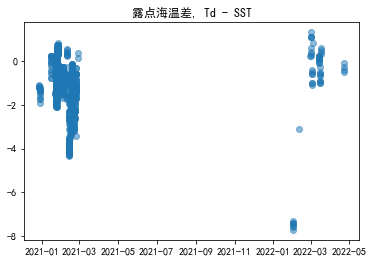

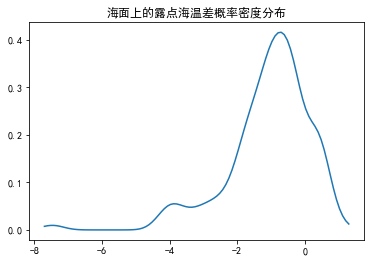

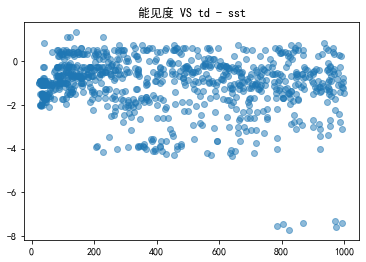

In [25]:
plt.scatter(ds_G7425_fogFilter.index, ds_G7425_fogFilter['td-sst'], marker='o',  alpha=0.5)
plt.title('露点海温差, Td - SST')
plt.show()

data_raw = ds_G7425_fogFilter['td-sst']
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.25)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('海面上的露点海温差概率密度分布')
plt.show()

plt.scatter(df_fog_inter[code_info['vis_01min']], ds_G7425_fogFilter['td-sst'], marker='o',  alpha=0.5)
plt.title('能见度 VS td - sst')
plt.show()

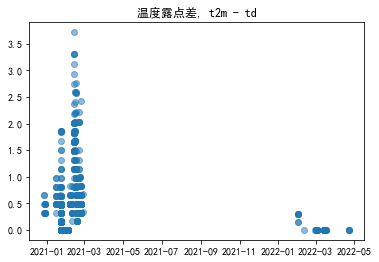

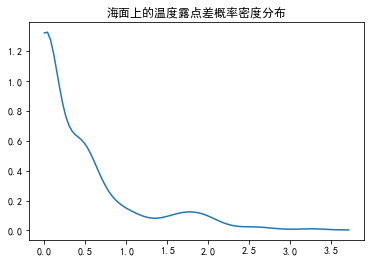

In [26]:
plt.scatter(ds_G7425_fogFilter.index, ds_G7425_fogFilter['t-td'], marker='o',  alpha=0.5)
plt.title('温度露点差, t2m - td')
plt.show()

data_raw = ds_G7425_fogFilter['t-td']
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.25)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('海面上的温度露点差概率密度分布')
plt.show()

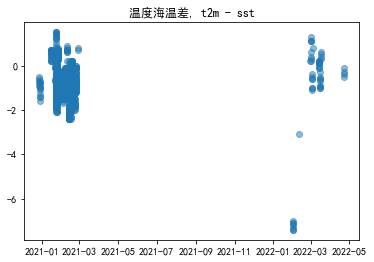

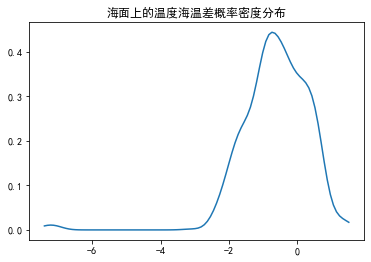

In [27]:
# 温度海温差
plt.scatter(ds_G7425_fogFilter.index, ds_G7425_fogFilter['t-sst'], marker='o',  alpha=0.5)
plt.title('温度海温差, t2m - sst')
plt.show()

data_raw = ds_G7425_fogFilter['t-sst']
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.25)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('海面上的温度海温差概率密度分布')
plt.show()

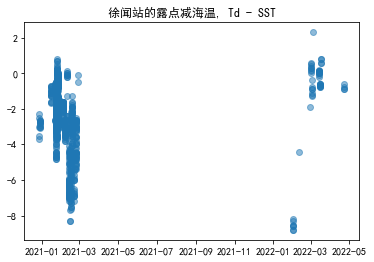

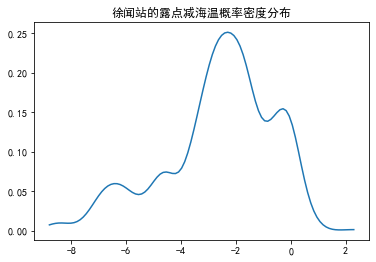

In [28]:
xuwen_td_sst = df_fog_inter[code_info['td']].values - ds_G7425_fogFilter['SeaTemperature'].values
plt.scatter(ds_G7425_fogFilter.index, xuwen_td_sst, marker='o',  alpha=0.5)
plt.title('徐闻站的露点减海温, Td - SST')
plt.show()

data_raw = xuwen_td_sst
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.2)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('徐闻站的露点减海温概率密度分布')
plt.show()

In [29]:
# TODO 能见度, T-Td, Td-SST 三维可视化
ds_G7425_valid = ds_G7425.dropna(subset=['SeaTemperature', 'RelativeHumidity','Temperature'])
utc_G7425_index = ds_G7425_valid.index.to_series() + pd.Timedelta(-8,unit='h')
df_59754_inter_index = df_59754.index.intersection(utc_G7425_index)
df_59754_inter = df_59754.loc[df_59754_inter_index]
df_59754_inter.index = df_59754_inter_index.to_series() + pd.Timedelta(8,unit='h')
ds_G7425_valid_inter = ds_G7425_valid.loc[df_59754_inter.index]


In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(projection='3d')

t_td = df_59754_inter[code_info['t2m']].loc[df_59754_inter[code_info['vis_01min']]>1000] - df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]>1000]
td_sst = df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]>1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
vis = df_59754_inter[code_info['vis_01min']].loc[df_59754_inter[code_info['vis_01min']]>1000].values
ax.scatter(td_sst, t_td, vis, marker='.', s=0.2, alpha=0.3)

t_td = df_59754_inter[code_info['t2m']].loc[df_59754_inter[code_info['vis_01min']]<=1000] - df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]<=1000]
td_sst = df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]<=1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
vis = df_59754_inter[code_info['vis_01min']].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
ax.scatter(td_sst, t_td, vis, marker='^', s=5.0, alpha=0.5)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)
ax.set_xlabel('td - sst', fontsize=15)
ax.set_ylabel('t2m - td', fontsize=15)
ax.set_zlabel('vis', fontsize=15)
ax.set_title('气温/露点/能见度关系散点图', fontsize=20)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(projection='3d')

rhum = ds_G7425_valid_inter['RelativeHumidity'].values*units.percent
temp = ds_G7425_valid_inter['Temperature'].values*units.degC
td = mpcalc.dewpoint_from_relative_humidity(temp, rhum)
ds_G7425_valid_inter['Dewpoint'] = td

t_td = df_59754_inter[code_info['t2m']].loc[df_59754_inter[code_info['vis_01min']]>1000] - df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]>1000]
td_sst = df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]>1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
td_sst_ocean = ds_G7425_valid_inter['Dewpoint'].loc[df_59754_inter[code_info['vis_01min']]>1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
vis = df_59754_inter[code_info['vis_01min']].loc[df_59754_inter[code_info['vis_01min']]>1000].values
t2m_ocean = ds_G7425_valid_inter['Temperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
ax.scatter(td_sst_ocean, t_td, vis, marker='.', s=0.2, alpha=0.3)


t_td = df_59754_inter[code_info['t2m']].loc[df_59754_inter[code_info['vis_01min']]<=1000] - df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]<=1000]
td_sst = df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]<=1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
td_sst_ocean = ds_G7425_valid_inter['Dewpoint'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
vis = df_59754_inter[code_info['vis_01min']].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
t2m_ocean = ds_G7425_valid_inter['Temperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
ax.scatter(td_sst_ocean, t_td, vis, marker='^', s=5.0, alpha=0.5)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)
ax.set_xlabel('td - sst', fontsize=15)
ax.set_ylabel('t2m - td', fontsize=15)
ax.set_zlabel('vis', fontsize=15)
ax.set_title('气温/露点/能见度关系散点图', fontsize=20)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(projection='3d')

rhum = ds_G7425_valid_inter['RelativeHumidity'].values*units.percent
temp = ds_G7425_valid_inter['Temperature'].values*units.degC
td = mpcalc.dewpoint_from_relative_humidity(temp, rhum)
ds_G7425_valid_inter['Dewpoint'] = td

t_td = df_59754_inter[code_info['t2m']].loc[df_59754_inter[code_info['vis_01min']]>1000] - df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]>1000]
td_sst = df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]>1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
td_sst_ocean = ds_G7425_valid_inter['Dewpoint'].loc[df_59754_inter[code_info['vis_01min']]>1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
vis = df_59754_inter[code_info['vis_01min']].loc[df_59754_inter[code_info['vis_01min']]>1000].values
t2m_ocean = ds_G7425_valid_inter['Temperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
sst = ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
ax.scatter(t2m_ocean - sst, t_td, vis, marker='.', s=0.2, alpha=0.3)


t_td = df_59754_inter[code_info['t2m']].loc[df_59754_inter[code_info['vis_01min']]<=1000] - df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]<=1000]
td_sst = df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]<=1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
td_sst_ocean = ds_G7425_valid_inter['Dewpoint'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
vis = df_59754_inter[code_info['vis_01min']].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
t2m_ocean = ds_G7425_valid_inter['Temperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
sst = ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<1000].values
ax.scatter(t2m_ocean - sst, t_td, vis, marker='^', s=5.0, alpha=0.5)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)
ax.set_xlabel('t2m_ocean - sst', fontsize=15)
ax.set_ylabel('t2m - td', fontsize=15)
ax.set_zlabel('vis', fontsize=15)
ax.set_title('气温/露点/能见度关系散点图', fontsize=20)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(projection='3d')

rhum = ds_G7425_valid_inter['RelativeHumidity'].values*units.percent
temp = ds_G7425_valid_inter['Temperature'].values*units.degC
td = mpcalc.dewpoint_from_relative_humidity(temp, rhum)
ds_G7425_valid_inter['Dewpoint'] = td

t_td = df_59754_inter[code_info['t2m']].loc[df_59754_inter[code_info['vis_01min']]>1000] - df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]>1000]
td_sst = df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]>1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
td_sst_ocean = ds_G7425_valid_inter['Dewpoint'].loc[df_59754_inter[code_info['vis_01min']]>1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
vis = df_59754_inter[code_info['vis_01min']].loc[df_59754_inter[code_info['vis_01min']]>1000].values
t2m_ocean = ds_G7425_valid_inter['Temperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
sst = ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]>1000].values
ax.scatter(td_sst_ocean, t_td, t2m_ocean, marker='.', s=0.2, alpha=0.3)


t_td = df_59754_inter[code_info['t2m']].loc[df_59754_inter[code_info['vis_01min']]<=1000] - df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]<=1000]
td_sst = df_59754_inter[code_info['td']].loc[df_59754_inter[code_info['vis_01min']]<=1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
td_sst_ocean = ds_G7425_valid_inter['Dewpoint'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values - ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
vis = df_59754_inter[code_info['vis_01min']].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
t2m_ocean = ds_G7425_valid_inter['Temperature'].loc[df_59754_inter[code_info['vis_01min']]<=1000].values
sst = ds_G7425_valid_inter['SeaTemperature'].loc[df_59754_inter[code_info['vis_01min']]<1000].values
ax.scatter(td_sst_ocean, t_td, t2m_ocean, marker='^', s=5.0, alpha=0.5)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)
ax.set_xlabel('td_sst_ocean', fontsize=15)
ax.set_ylabel('t2m - td', fontsize=15)
ax.set_zlabel('t2m_ocean', fontsize=15)
ax.set_title('气温/露点/能见度关系散点图', fontsize=20)
plt.show()

In [40]:
rhum = ds_G7425_valid_inter['RelativeHumidity'].values*units.percent
temp = ds_G7425_valid_inter['Temperature'].values*units.degC
td = mpcalc.dewpoint_from_relative_humidity(temp, rhum)
ds_G7425_valid_inter['Dewpoint'] = td
ds_G7425_valid_inter['t_td_station'] = df_59754_inter[code_info['t2m']].values -  df_59754_inter[code_info['td']].values
ds_G7425_valid_inter['td_sst_station'] = df_59754_inter[code_info['td']].values -  ds_G7425_valid_inter['SeaTemperature'].values
ds_G7425_valid_inter['vis_01min'] = df_59754_inter[code_info['vis_01min']].values
ds_G7425_valid_inter['td_sst_ocean'] = ds_G7425_valid_inter['Dewpoint'] - ds_G7425_valid_inter['SeaTemperature']
ds_G7425_valid_inter['t_td_ocean'] =  ds_G7425_valid_inter['Temperature'] - ds_G7425_valid_inter['Dewpoint']


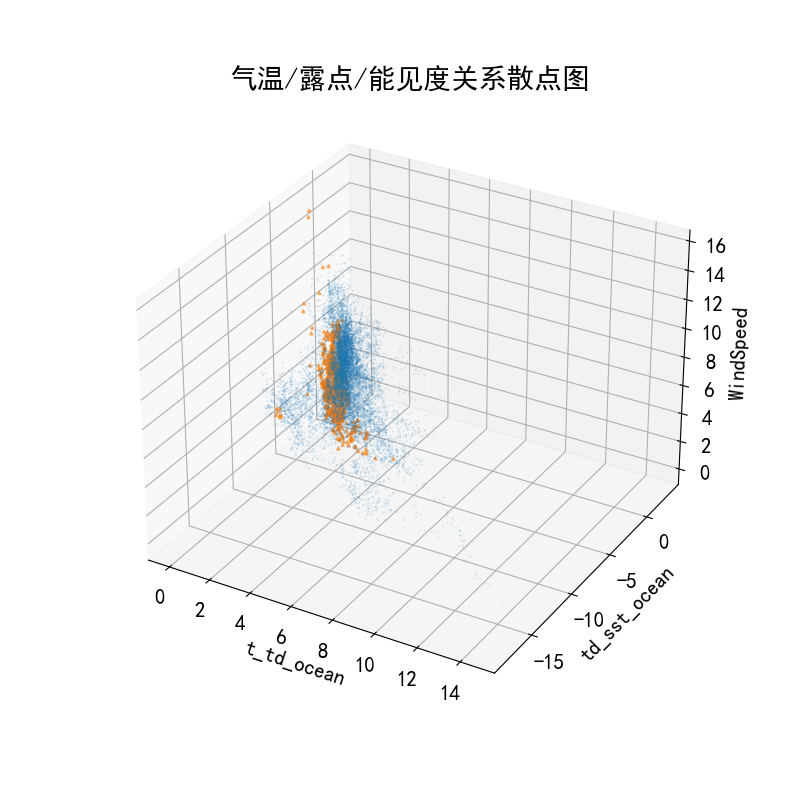

In [43]:
# filter 月份 [1,2,3,4,9, 10, 11, 12]
# filter hour [0,1,2,3,4,5,6,7,8,9,22,23]
df_59754_inter_filter = df_59754_inter.loc[df_59754_inter[code_info["hour"]].isin([16,17,19,19,20,21,22,23,0,1,14,15]) & df_59754_inter[code_info["month"]].isin([1,2,3,4,9, 10, 11, 12])]
ds_G7425_valid_inter_filter = ds_G7425_valid_inter.loc[df_59754_inter_filter.index]




x_var = 't_td_ocean'
y_var = 'td_sst_ocean'
z_var = 'WindSpeed'

x_all = ds_G7425_valid_inter_filter[x_var]
y_all = ds_G7425_valid_inter_filter[y_var]
z_all = ds_G7425_valid_inter_filter[z_var]

x01 = x_all.loc[df_59754_inter_filter[code_info['vis_01min']]>1000].values
y01 = y_all.loc[df_59754_inter_filter[code_info['vis_01min']]>1000].values
z01 = z_all.loc[df_59754_inter_filter[code_info['vis_01min']]>1000].values

x02 = x_all.loc[df_59754_inter_filter[code_info['vis_01min']]<=1000].values
y02 = y_all.loc[df_59754_inter_filter[code_info['vis_01min']]<=1000].values
z02 = z_all.loc[df_59754_inter_filter[code_info['vis_01min']]<=1000].values

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(projection='3d')
ax.scatter(x01, y01, z01, marker='.', s=0.2, alpha=0.3)
ax.scatter(x02, y02, z02, marker='^', s=5.0, alpha=0.5)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.zaxis.set_tick_params(labelsize=15)
ax.set_xlabel(x_var, fontsize=15)
ax.set_ylabel(y_var, fontsize=15)
ax.set_zlabel(z_var, fontsize=15)
ax.set_title('气温/露点/能见度关系散点图', fontsize=20)
plt.show()
